In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from datetime import date
%matplotlib inline

In [3]:
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ['SPY']

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
today = date.today()
end_date = pd.Timestamp(today.strftime("%Y-%m-%d"), tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df


# Remove the time component of the data
df.index = df.index.date

In [5]:
df.SPY.tail()

,open,high,low,close,volume
2020-07-27,321.63,323.41,320.775,323.18,42586195
2020-07-28,322.43,323.64,320.850,321.20,89313354
2020-07-29,322.12,325.73,322.075,325.09,87237532
2020-07-30,321.90,324.41,319.640,323.98,106103025
2020-07-31,325.90,326.61,321.330,326.55,129516546


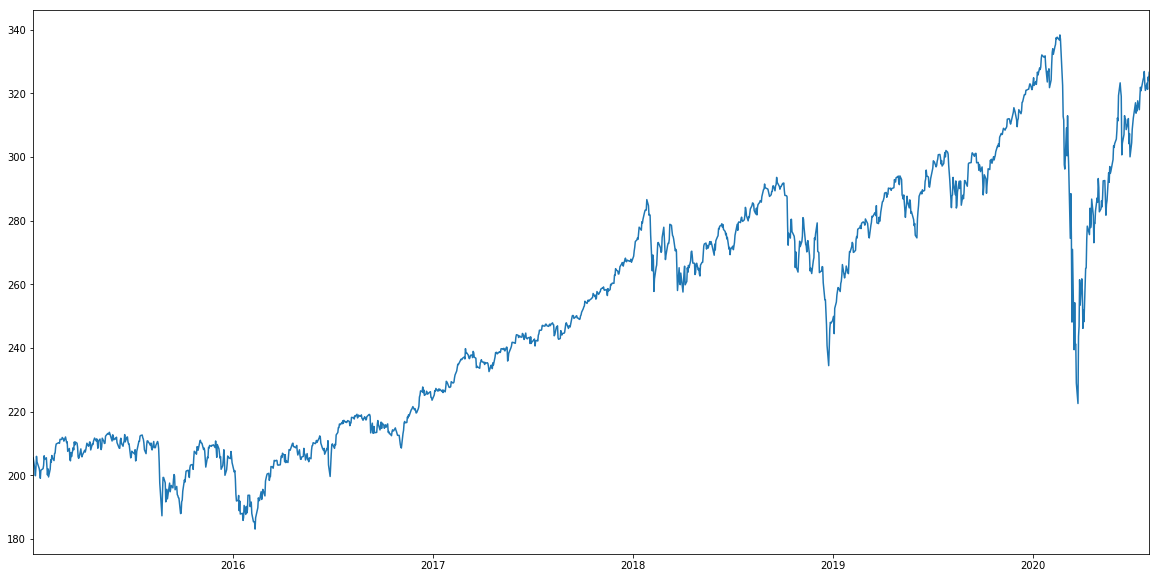

In [6]:
df.SPY.close.plot(figsize=(20,10))

In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller_ba=adfuller(df.SPY.close)

In [8]:
def s_dickey_fuller(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value:        %f ' % result[1])
    print('Lags used:      %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
    if result[1]<0.05:
        print('\The p-value is below the significance level of 0.05. TS is stationary.\n\nWe can reject the hypothesis that the time series is non-stationary.')
    else: 
        print('\p-value is above the significance level of 0.05. TS is not stationary \n\nWe cannot reject the hypothesis that the time series is non-stationary.')
    
#http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [9]:
daily_returns=df.pct_change()*100
daily_returns = daily_returns.dropna()
daily_returns.tail()

SPY                                          
                open      high       low     close      volume
2020-07-27  0.211871  0.441007  0.478941  0.723057  -63.905366
2020-07-28  0.248733  0.071117  0.023381 -0.612662  109.723724
2020-07-29 -0.096145  0.645779  0.381798  1.211083   -2.324201
2020-07-30 -0.068298 -0.405244 -0.756035 -0.341444   21.625432
2020-07-31  1.242622  0.678154  0.528720  0.793259   22.066780

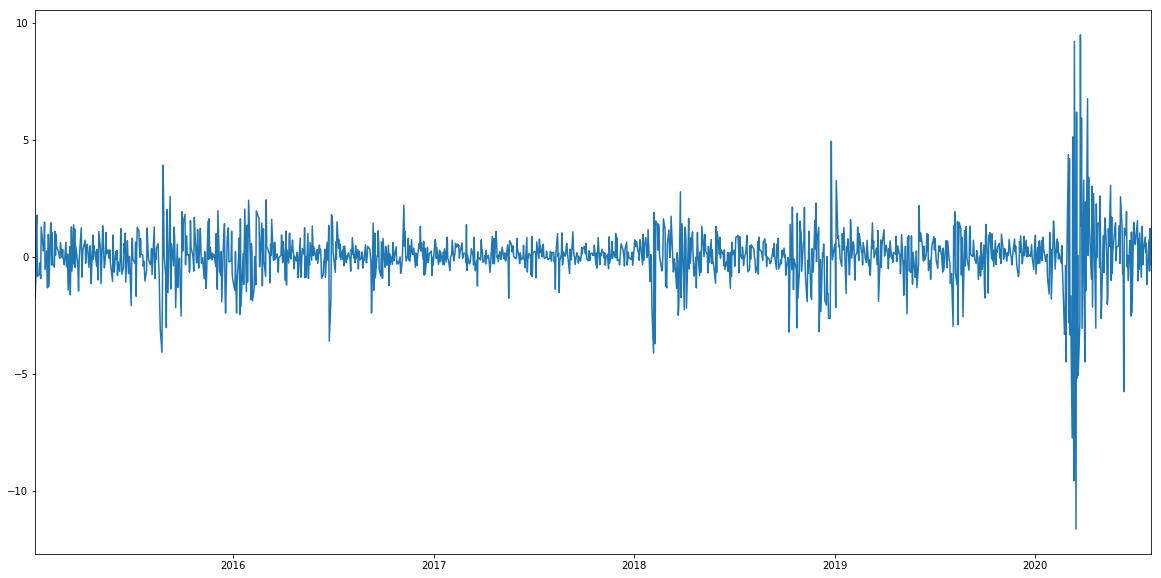

In [10]:
daily_returns.SPY.close.plot(figsize=(20,10)) 

In [11]:
s_dickey_fuller(daily_returns.SPY.close)

ADF Statistic: -11.596827
p-value:        0.000000 
Lags used:      8
Critical Values:
1%: -3.435
5%: -2.864
10%: -2.568
\The p-value is below the significance level of 0.05. TS is stationary.

We can reject the hypothesis that the time series is non-stationary.


In [12]:
avg_daily_return = daily_returns.SPY.close.mean()
avg_daily_return

0.04002662340081114

# ARIMA Model

In [13]:
from statsmodels.tsa.arima_model import ARIMA
model1 = ARIMA(daily_returns.SPY.close, order=(2, 1, 1))

C:\Users\zhaoy\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\zhaoy\Anaconda3\envs\pyvizenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
results_arima = model1.fit()

In [15]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 1403
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2191.209
Method:                       css-mle   S.D. of innovations              1.151
Date:                Sat, 01 Aug 2020   AIC                           4392.418
Time:                        13:42:35   BIC                           4418.649
Sample:                             1   HQIC                          4402.223
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.799e-05   6.83e-05      0.556      0.578   -9.59e-05       0.000
ar.L1.D.close    -0.1906      0.027     -7.153      0.000      -0.243      -0.138
ar.L2.D.close     0.0809      0.027      3.038      0.002       0.029       0.133
ma.L1.D.close    -1.0000      0.002   -535.707      0.000      -1.004      -0.996
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.5297           +0.0000j            2.5297            0.5000
AR.2            4.8846           +0.0000j            4.8846            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

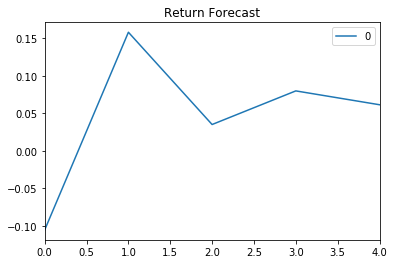

In [16]:
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="Return Forecast")

In [17]:
results_arima.forecast(steps=5)[0]

array([-0.1051577 ,  0.15793758,  0.0351307 ,  0.0798697 ,  0.06144677])

In [18]:
print(f'forecast {results_arima.forecast()[0]}')
print(f'Standard Error {results_arima.forecast()[1]}')
print(f'Confidence Interval {results_arima.forecast()[2]}')

forecast [-0.1051577]
Standard Error [1.15051549]
Confidence Interval [[-2.36012662  2.14981122]]


# GARCH MODEL

In [29]:
from arch import arch_model

In [39]:
daily_returns.index = pd.to_datetime(daily_returns.index)

In [40]:
model = arch_model(daily_returns.SPY.close, mean="Zero", vol="GARCH", p=1, q=1)

In [41]:
res = model.fit(disp="off")

In [42]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1693.14
Distribution:                  Normal   AIC:                           3392.28
Method:            Maximum Likelihood   BIC:                           3408.02
                                        No. Observations:                 1404
Date:                Sat, Aug 01 2020   Df Residuals:                     1401
Time:                        13:47:50   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0383  1.111e-02      3.451  5.576e-04 [1.657e-02,6.012e-02]
alpha[1]       0.2110  3.516e-02      5.999  1.981e-09     [  0.142,  0.280]
beta[1]        0.7561  3.041e-02     24.866 1.742e-136     [  0.697,  0.816]
============================================================================

Covariance estimator: robust
"""

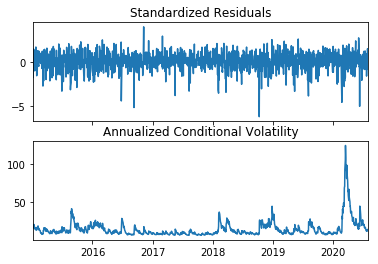

In [43]:
fig = res.plot(annualize='D')

In [44]:
import arch as arch
# Construct Volatility Forecasts for the next 3 days
forecast_horizon = 10
# Take the last day of the data we used above. 
# If forecast horizon is 3, then the resulting 'h.1', 'h.2', and 'h.3' 
# are the forecasts for the following 3 days.
forecasts = res.forecast(start='2020-07-31', horizon=forecast_horizon)
forecasts

In [45]:
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10
2020-07-31,13.195885,13.343956,13.485606,13.621192,13.751042,13.875462,13.994734,14.10912,14.218866,14.324198


In [37]:
final = intermediate.dropna().T
final

,2020-07-31 00:00:00
h.01,13.195885
h.02,13.343956
h.03,13.485606
h.04,13.621192
h.05,13.751042
h.06,13.875462
h.07,13.994734
h.08,14.109120
h.09,14.218866
h.10,14.324198


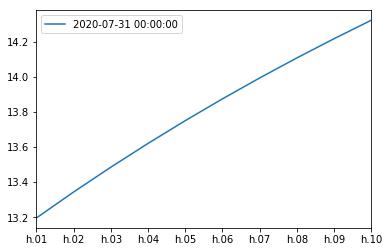

In [38]:
final.plot()